This code separates two dynamic topography fields into distinct objects and attempts to match the objects. A "hit", "miss" or "false alarm" is assigned depending on whether or not a match was found. Based on this, a performance diagram is plotted.

In [1]:
from __future__ import division
from plot import actual_plot
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours
from skimage.io import imshow
from scipy.ndimage import measurements
import multiprocessing as mp
from matplotlib import cm
from math import sqrt
import math
from mpl_toolkits.mplot3d import axes3d
import collections
from scipy.ndimage.filters import generic_filter as gf
import pandas as pd

In [2]:
def distance(lat1, lat2, lon1, lon2, radius=6371229.0):

    '''
    This routine calculates the distance between
    any longitude-latitude and returns the value in km
    '''
    
    pi = np.pi
#convert to radians
    lat1 *= pi/180
    lat2 *= pi/180
    lon1 *= pi/180
    lon2 *= pi/180

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return radius * c / 1000

In [3]:
def readin(path):
#reads in the dynamic topography fields
        field = np.loadtxt(path)[:,2]
        return np.reshape(field, (179,360))

In [4]:
def plot_field(array):
    
    '''
    This routine makes a 2-d plot of the 
    dynamic topography field
    '''
    
   # fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))
#    fig = plt.figure(figsize=(20,10))
    lat = np.linspace(89,-89,179)
    lon = np.linspace(-179,180,360)
    LON, LAT = np.meshgrid(lon,lat)
    arr = []
    for row in array:
        arr.append([])
        for j in row:
            arr[-1].append(j)
#fig, ax = plt.subplots()
    #c = ax.pcolormesh(LON,LAT,arr,cmap="turbo")

    plt.pcolormesh(LON,LAT,arr,cmap="turbo")
    #surf = ax.plot_surface(LON, LAT, array, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    #plt.show()

In [5]:
def convert_to_gray(x):
    
    '''
    This routine converts a dynamic topography field, x, 
    to a grayscale
    '''
    
    smin=0; smax=255
    x_gray = smin + (x - np.min(x))*(smax - smin)/ \
            (np.max(x) - np.min(x))
    return x_gray

In [6]:
def circular_filter(image_data, radius):
    
    '''
    This routine creates performs a convolution 
    between the field and a disk. The disk is 
    modelled as circular filter.
    
    The filter is then placed on every grid point and the 
    average of the values within the circle centered at 
    the grid point is found.
        
    Then the value at the central grid point is replaced
    with this average.
       
    This is essentially a smoothing procedure to remove
    small-scale variations in the input field
    '''
    
    kernel = np.zeros((2*radius+1, 2*radius+1))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1                
    filtered_image = gf(image_data, np.mean, mode="constant",footprint = kernel)
    return filtered_image

In [7]:
def identify(arr, radius=20, thresh=50):
    
    '''
    This routine calls "circular_filter" and performs a
    convolution.
       
    The convolved field is then thresholded to create a mask 
    of 0's and 1's which is then placed on the original field
       
    This procedure helps to create distinct objects similar to 
    what a human would identify on a map
       
    Once the objects are clearly delineated, they entire field 
    is binarized and a number of Sci-kit Image tools are used
    to label and extract properties of each object
       
    Finally, the coordinates as well as the thresholded field
    is returned
    '''
    
    filtered = circular_filter(arr,radius)
    thresholded = filtered > thresh
    final = np.where(thresholded==1,abs(arr),0)
    
    #convert from topography to grayscale
    #gray = convert_to_gray(final)

    #binarize image
    bw = (final > 0)*1
    #label binarized image then extract properties of labelled regions
    label_img = label(bw)
    regions = regionprops(label_img)
    
    
    coords_list = list()
    centroid_list = list()
    for region in regions:
        coords = region.coords
      #  coords[:,0] = 89 - coords[:,0]
       # coords[:,1] += -179
        if(len(coords) >= 100):
            coords_list.append(coords.tolist())
        
       # centroid_tuple = region.centroid
        #cast tuple to list coz assignment to tuple not supported
        #centroid = list()
        #centroid.append(89 - centroid_tuple[0])
        #centroid.append(centroid_tuple[1] - 179)
      #  centroid_list.append(centroid)
        
    return coords_list, final

In [8]:
def extract_props(object_coords, field):
    
    '''
    This routine reads in the coordinates of all identified 
    objects in a field and returns their centroid,
    orientation, area, bounding contours as well as
    the original coordinates themselves
    '''
    
    combined_obj_props = list()
    for object_coord in object_coords:
        obj_props = list()
        objct = grid_object(object_coord, field)
    
        #Convert to grayscale and binarize
        gray = convert_to_gray(objct)
        thresh = 0
        bw = (gray > thresh) * 1
    
        #label binarized object and extract region properties
        label_img = label(bw)
        region = regionprops(label_img)
        
        obj_props.append(region[0].centroid)
        obj_props.append(region[0].orientation)
        obj_props.append(region[0].area)
        obj_props.append(find_contours(bw,0)) #will be used later for Procrustes analysis
        obj_props.append(object_coord)
        
        combined_obj_props.append(obj_props)
        
    return combined_obj_props

In [9]:
def performance_diagram():
    
    #Code modified from https://pypi.org/project/verif/0.4.0/
    
    import matplotlib.pyplot as mpl    
    mpl.tick_params(labelsize=30)
         
    num_max_points = 20

    # Plot points
    #sr = 1 - far
    #pod = pod
    #far = far
    
   # fig = plt.figure(figsize=(20,10))
      
    #mpl.scatter(sr, pod,s=1000,marker='P')
           
        # Plot bias lines
    biases = [0.3, 0.5, 0.8, 1, 1.3, 1.5, 2, 3, 5, 10]
    for i in range(len(biases)):
        bias = biases[i]
        label = ""
        #if i == 0:
        label = "Bias frequency"
        mpl.plot([0, 1], [0, bias], 'k-', label=label)
       # if bias <= 1:
        #    mpl.text(1, bias, "%2.1f" % (bias),fontsize=20)
       # else:
        #    mpl.text(1.0/bias, 1, "%2.1f" % (bias),fontsize=20)

        # Plot threat/CSI score lines
    threats = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 100)
        label = ""
        #if i == 0:
        label = "Threat score"
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        mpl.plot(x, y, 'k--', label=label)
        xx = 2.0 / (1 + 1.0/threat)
        mpl.text(xx, xx, str(threat), fontsize=25)

    mpl.xlabel("Success ratio (1 - FAR)", fontsize=30)
    mpl.ylabel("Probability of detection", fontsize=30)
    mpl.xlim([0, 1])
    mpl.ylim([0, 1])
    #mpl.xticks([])
    #mpl.yticks([])
    mpl.gca().set_aspect(1)  
    #mpl.show()

In [10]:
def procrustes(X, Y, scaling=True, reflection=False, interpolator='True'):
    """
    
    Ayo extended the code to account for matrices with unequal sizes
    
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Parameters
    ----------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Returns
    -------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    from scipy.interpolate import interp1d

    if (X.shape[0] < Y.shape[0]):
        if interpolator == True:
            val = np.array(range(X.shape[0]))
            xnew = np.linspace(val.min(), val.max(), Y.shape[0])
            f = interp1d(val, X, axis=0)
            X = f(xnew)
        else:
            X = np.pad(X, ((0, Y.shape[0] - X.shape[0]), (0, 0)), 'constant')
            temp = X
            X = Y
            Y = temp
    elif (X.shape[0] > Y.shape[0]):
        if interpolator == True:
            
            val = np.array(range(Y.shape[0]))
            ynew = np.linspace(val.min(), val.max(), X.shape[0])
            f = interp1d(val, Y, axis=0)
            Y = f(ynew)
        else:
            Y = np.pad(Y, ((0, X.shape[0] - Y.shape[0]), (0, 0)), 'constant')   
    
    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = np.linalg.norm(X0, 'fro')**2 #(X0**2.).sum()
    ssY = np.linalg.norm(Y0, 'fro')**2 #(Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)
        

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX
        

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [11]:
def matching(pred_props, ref_props, pred_field, ref_field, procr=True):
    
    '''
    This routine tries to match object in the true field
    with equivalent objects in the model field.
    
    Three metrics are calculated:
    
    Critical Success Index [CSI] = hits / (hits + misses + false alarms)
    Probability of Detection [POD] = hits / (hits + misses)
    False Alarm Ratio [FAR] = false alarms / (hits + false alarms)
    
    
    Definitions:
    
    Hit: If the object is found in both the test and model fields
    Miss: If the object is found in the test field but not the model field
    False Alarm: If the object is found in the model field but not in the true field
    '''
    hits = 0
    procrustes_sum = 0
    hits_list = list()
    contour_list = list()
    area_diff_list = list()
    orientation_diff_list = list()
    topo_diff_list = list()
    cent_diff_list = list()
    score_list = list()
    
    for ref_prop in ref_props:
        centroid_ref = ref_prop[0]
        orientation_ref = 361 + ref_prop[1]
        area_ref = ref_prop[2]
        coords_ref = ref_prop[-1]
        coords_ref_set = set(tuple(x) for x in ref_prop[-1])
        
        for pred_prop in pred_props:
            centroid_pred = pred_prop[0]
            orientation_pred = 361 + pred_prop[1]
            area_pred = pred_prop[2]
            coords_pred = pred_prop[-1]
            coords_pred_set = set(tuple(x) for x in pred_prop[-1])
            
            error = sqrt((centroid_ref[0] - centroid_pred[0])**2 +\
                        (centroid_ref[1] - centroid_pred[1])**2)
            intersection = len(coords_ref_set & coords_pred_set) / max(len(coords_ref_set), len(coords_pred_set))
       
            area_ratio = min(area_ref, area_pred) / max(area_ref, area_pred)
            
            if((intersection > 0.25) and (area_ratio > 0.4)):
                hits += 1
                pair = [coords_ref, coords_pred]
                hits_list.append(pair)
                #contour_list.append([ref_prop[-2], pred_prop[-2]])
                area_diff = abs((area_pred - area_ref) / (area_pred + area_ref))
                orientation_diff = abs((orientation_pred - orientation_ref) / (orientation_pred + orientation_ref))
                avg_topo_ref = np.mean(grid_object(coords_ref, ref_field))
                avg_topo_pred = np.mean(grid_object(coords_pred, pred_field))
                avg_topo_diff = abs((avg_topo_pred - avg_topo_ref) / (avg_topo_pred + avg_topo_ref))
                
                cent_dist_ref = centre_of_mass(grid_object(coords_ref, ref_field))
                cent_dist_pred = centre_of_mass(grid_object(coords_pred, pred_field))
                cent_diff = abs((cent_dist_pred - cent_dist_ref) / (cent_dist_pred + cent_dist_ref))
                
                score = area_diff + orientation_diff + avg_topo_diff + cent_diff
                
                score_list.append(score)
                
                #calculate Procrustes score and add avg_topo_diff
                d,_,_ = procrustes(np.asarray(ref_prop[-2][0]), np.asarray(pred_prop[-2][0]))
                procrustes_sum += (d + avg_topo_diff)
                #area_diff_list.append(area_diff)
                #orientation_diff_list.append(orientation_diff)
                #topo_diff_list.append(avg_topo_diff)
                #cent_diff_list.append(cent_diff)
                break
                
    misses = len(ref_props) - hits
    false_alarms = len(pred_props) - hits
    
    CSI = hits / (hits + misses + false_alarms)
    POD = hits / (hits + misses)
    FAR = false_alarms / (hits + false_alarms)
    
    #final skill score
    if procr:
        #Total score of 3
        if hits != 0:
            procr_score = procrustes_sum / hits
            final_score = procr_score + (1 - CSI) #CSI is 1 for perfect skill so we subtract from 1
        else:
            final_score = 3
    else:
    #Total score of 5
        if len(score_list) != 0:
            avg_score = sum(score_list) / len(score_list)
            final_score = avg_score + (1 - CSI) #CSI is 1 for perfect skill so we subtract from 1
        else:
            final_score = 5
    
    df = pd.DataFrame({"CSI":CSI, "POD":POD, "FAR":FAR, "SS":final_score}, index = [0])
    
    
    return df

In [12]:
def grid_object(object_name, array_name):
    
    '''
    This routine takes in the coordinates of an identified
    object and grids it onto the original field
    '''
    
    array = np.zeros((179,360))
    for i in range(len(object_name)):
        j = object_name[i][0]
        k = object_name[i][1]
        array[j,k] = abs(array_name[j,k])

    return array

In [13]:
def centre_of_mass(field):
    
    '''
    This routine calculates the centroid/center of mass
    of an object
    '''
    
    field_gray = convert_to_gray(field)
    com = measurements.center_of_mass(field_gray)
    
    #distance from com to origin
    dist_com_org = sqrt((com[0])**2 + (com[1])**2)
    
    return dist_com_org

In [14]:
def total_object_topo(objct, field):
    
    '''
    This routine calculates the total amount of topography
    contained within an object
    '''
    
    total_topo = 0.0
    for coords in objct:
        j = coords[0]; k = coords[1]
        total_topo += field[j, k]
    return total_topo

In [15]:
def norm_volume(object_list, field):
    
    '''
    This routine calculates a normalized volume for an object
    by dividing the total topography by the maximum topography
    '''
    abs_volume = list()
    for objct in object_list:
        max_topo = np.max(grid_object(objct, field))
        volume = total_object_topo(objct, field) / max_topo
        
        abs_volume.append(volume)
    
    return abs_volume

In [16]:
def up_sub(field, uplift=1):
    
    '''
    This routine separates the topography field into its
    uplift and subsidence components
    '''
    up_field = np.where(field < 0.0, 0.0, field)
    sub_field = np.where(field > 0.0, 0.0, -1.0 * field)
    
    if(uplift==1):
        return up_field
    else:
        return sub_field

In [17]:
time = "36_00"

a="009"
b="012"
c="015"
d="031"
e="014"
f="017"
g="032"

ref = up_sub(readin("../"+a+"/surface"+time),1)
rad = up_sub(readin("../"+b+"/surface"+time),1)
hor = up_sub(readin("../"+c+"/surface"+time),1)
s20 = up_sub(readin("../"+d+"/surface"+time),1)
rad_assim = up_sub(readin("../"+e+"/surface"+time),1)
hor_assim = up_sub(readin("../"+f+"/surface"+time),1)
s20_assim = up_sub(readin("../"+g+"/surface"+time),1)

topo_up_dict = {"ref":ref,"rad":rad,"hor":hor,"s20":s20,\
            "rad_assim":rad_assim,"hor_assim":hor_assim,\
                "s20_assim":s20_assim}

In [18]:
#Break down uplift field into distinct objects
object_up_dict = dict() #dictionary of coordinates of identified objects
final_up = dict() #dictionary containg the final thresholded field
object_up_props_dict = dict() #dictionary of area, orientation, centroid and contours for every object
scores_up_dict = dict() #dictionary of CSI scores as a list(hits, misses, false_alarms)
csi_up = list(); pod_up = list(); far_up = list()
area_diff_up = list(); orientation_diff_up = list(); avg_topo_diff_up = list()

for name, array in topo_up_dict.items():
    object_up_dict[name], final_up[name] = identify(array,20,50)

#extract properties of individual objects
for name, object_coords in object_up_dict.items():
    field = topo_up_dict[name]
    object_up_props_dict[name] = extract_props(object_coords,field)
    
#match objects between reference and other fields one at a time
for name, object_prop in object_up_props_dict.items():
    scores_up_dict[name] = matching(object_prop, object_up_props_dict["ref"],topo_up_dict[name],
                                   topo_up_dict["ref"], procr=True)

/home/ataiwo/.local/lib/python2.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/ataiwo/.local/lib/python2.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


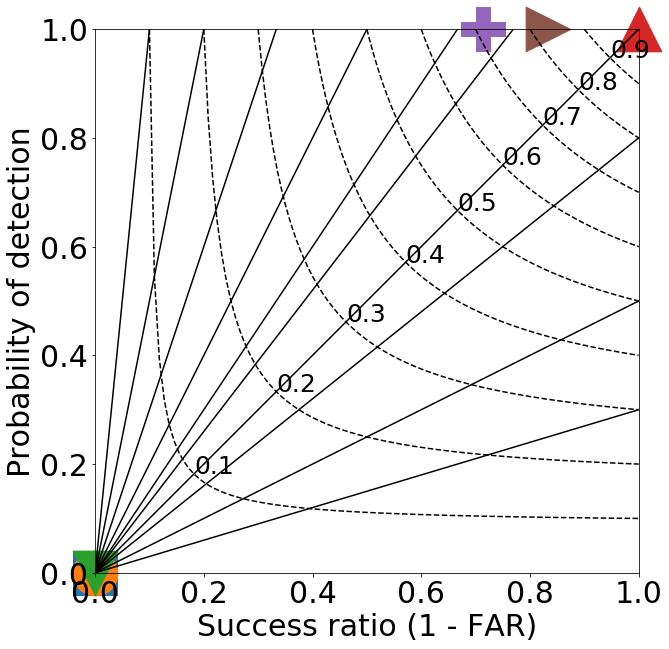

In [19]:
#plot performance diagram
perform_list = [scores_up_dict["rad"],scores_up_dict["hor"],scores_up_dict["s20"],
               scores_up_dict["rad_assim"],scores_up_dict["hor_assim"],scores_up_dict["s20_assim"]]

markers = ["s","o","v","^","P",">"]
labels = ["Rad.", "Horiz.", "S20", "Rad_assim", "Hor_assim", "S20_assim"]
fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(perform_list)):
    sr = 1 - perform_list[i]["FAR"]
    pod = perform_list[i]["POD"]
    
    #Make scatter plot of
    ax.scatter(sr, pod, s=2000,marker=markers[i], clip_on=False, label=labels[i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', fontsize=40, bbox_to_anchor=(1, 0.5))
performance_diagram()
plt.show()

In [20]:
#scores_up_dict["hor"]

In [21]:
#plot_field(final_up["ref"])
#plt.show()
#plot_field(final_up["hor_assim"])

In [22]:
#plot_field(grid_object(scores_up_dict["s20_assim"][-1][3][0], topo_up_dict["ref"]))
#plt.show()
#plot_field(grid_object(scores_up_dict["s20_assim"][-1][3][0], topo_up_dict["s20_assim"]))

In [23]:
ref = up_sub(readin("../"+a+"/surface"+time),0)
rad = up_sub(readin("../"+b+"/surface"+time),0)
hor = up_sub(readin("../"+c+"/surface"+time),0)
s20 = up_sub(readin("../"+d+"/surface"+time),0)
rad_assim = up_sub(readin("../"+e+"/surface"+time),0)
hor_assim = up_sub(readin("../"+f+"/surface"+time),0)
s20_assim = up_sub(readin("../"+g+"/surface"+time),0)


topo_sub_dict = {"ref":ref,"rad":rad,"hor":hor,"s20":s20,\
            "rad_assim":rad_assim,"hor_assim":hor_assim,\
                "s20_assim":s20_assim}

In [24]:
#Break down subsidence field into distinct objects
object_sub_dict = dict()
final_sub = dict()
object_sub_props_dict = dict() #dictionary of area, orientation, centroid and contours for every object
scores_sub_dict = dict()

for name, array in topo_sub_dict.items():
    object_sub_dict[name], final_sub[name] = identify(array,20,50)

#extract properties of individual object
for name, object_coords in object_sub_dict.items():
    field = topo_sub_dict[name]
    object_sub_props_dict[name] = extract_props(object_coords,field)

#match objects between reference and other fields one at a time
for name, object_prop in object_sub_props_dict.items():
    scores_sub_dict[name] = matching(object_prop, object_sub_props_dict["ref"], topo_sub_dict[name],
                                   topo_sub_dict["ref"], procr=True)

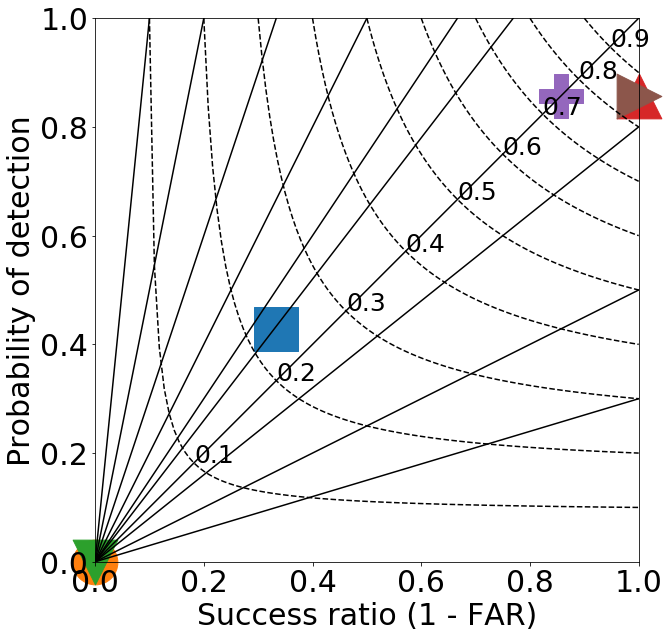

In [25]:
#plot performance diagram
perform_list = [scores_sub_dict["rad"],scores_sub_dict["hor"],scores_sub_dict["s20"],
               scores_sub_dict["rad_assim"],scores_sub_dict["hor_assim"],scores_sub_dict["s20_assim"]]

markers = ["s","o","v","^","P",">"]
labels = ["Rad.", "Horiz.", "S20", "Rad_assim", "Hor_assim", "S20_assim"]
fig, ax = plt.subplots(figsize=(20,10))
for i in range(len(perform_list)):
    sr = 1 - perform_list[i]["FAR"]
    pod = perform_list[i]["POD"]
    ax.scatter(sr, pod, s=2000, marker=markers[i], clip_on=False, label=labels[i])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', fontsize=40, bbox_to_anchor=(1, 0.5))
#ax.legend(loc="best", fontsize=40)
performance_diagram()
plt.show()

In [26]:
#test_ref = topo_up_dict["ref"] - topo_sub_dict["ref"]
#plot_field(test_ref)
#plt.show()

In [27]:
#test_filtered = final_up["ref"] - final_sub["ref"]
#plot_field(test_filtered)
#plt.show()

In [28]:
#scores_up_dict["hor"]["SS"][0]

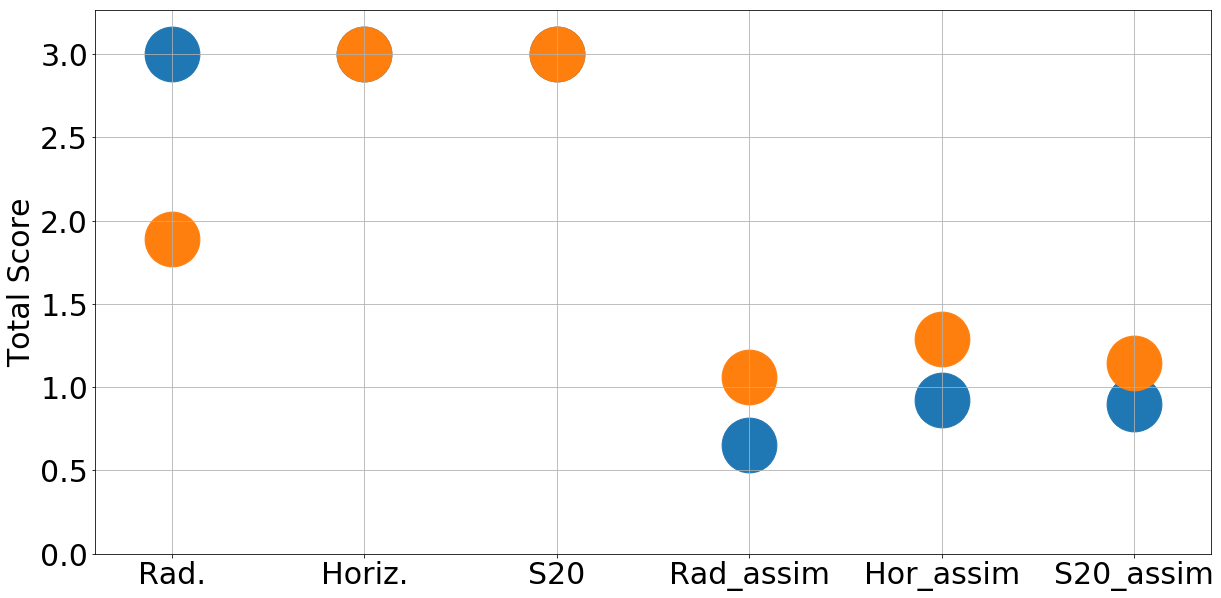

In [38]:
#plot final skill score
score_up_list = [scores_up_dict["rad"]["SS"][0],scores_up_dict["hor"]["SS"][0],scores_up_dict["s20"]["SS"][0],
               scores_up_dict["rad_assim"]["SS"][0],scores_up_dict["hor_assim"]["SS"][0],
                 scores_up_dict["s20_assim"]["SS"][0]]
score_sub_list = [scores_sub_dict["rad"]["SS"][0],scores_sub_dict["hor"]["SS"][0],scores_sub_dict["s20"]["SS"][0],
               scores_sub_dict["rad_assim"]["SS"][0],scores_sub_dict["hor_assim"]["SS"][0],
                  scores_sub_dict["s20_assim"]["SS"][0]]

labels = ["Rad.", "Horiz.", "S20", "Rad_assim", "Hor_assim", "S20_assim"]
width = 0.35
fig, ax = plt.subplots(figsize=(20,10))
plt.tick_params(labelsize=30)

#ax.plot(labels, score_up_list, width, label='Uplift')
#ax.plot(labels, score_sub_list, width, label='Subsidence')
plt.scatter(labels, score_up_list, clip_on=False, s=3000, label="Uplift")
plt.scatter(labels, score_sub_list, clip_on=False, s=3000, label="Subsidence")
#plt.ylim((0,3))
plt.ylim(bottom=0)
plt.ylabel("Total Score", fontsize=30)
#plt.legend(fontsize=30, ncol=2)
plt.grid()
plt.show()

In [30]:
#plot_field(final_sub["ref"])
#plt.show()
#plot_field(final_sub["rad_assim"])

In [31]:
#plot_field(grid_object(object_sub_dict["rad_assim"][0], topo_sub_dict["rad_assim"]))
#plt.show()
#plot_field(grid_object(object_sub_dict["ref"][4], topo_sub_dict["ref"]))

In [32]:
#test = grid_object(object_sub_dict["ref"][0], topo_sub_dict["ref"])
#gray = convert_to_gray(test)

#thresh = 0
#bw = (gray > thresh) * 1

#plt.imshow(bw)

#label_img = label(bw)
#regions = regionprops(label_img)

#image = bw

#fig, ax = plt.subplots(1,2,figsize=(15,5))
#ax[0].imshow(image, cmap=plt.cm.gray)

#for props in regions:
#    print(props.area)
#    y0, x0 = props.centroid
 #   orientation = props.orientation
 #   x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
 #   y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
 #   x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
 #   y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

 #   ax[0].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
 #   ax[0].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
 #   ax[0].plot(x0, y0, '.g', markersize=15)

 #   minr, minc, maxr, maxc = props.bbox
 #   bx = (minc, maxc, maxc, minc, minc)
 #   by = (minr, minr, maxr, maxr, minr)
 #   ax[0].plot(bx, by, '-b', linewidth=2.5)

  #  plot_field(test)
#ax.axis((0, 600, 600, 0))
#plt.show()